# 3. Model Inference
Tahapan ini digunakan untuk menerapkan model yang telah dibuat ke dataset remote sensing yang telah mengalami koreksi dan masking.

In [1]:
import os
import joblib
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import show

In [ ]:
# --- 1. CONFIGURATION ---
raster_path = r'data\corrected\corrected_s2_giliketapang_2018-05-31.tif'
model_path = r'model\xgboost_sdb_model.pkl'
output_path = r'output'
output_filename = 'SDB_Depth_Map_GiliKetapang.tif'

os.makedirs(output_path, exist_ok=True)

# --- 2. LOAD DATA ---
print("Loading Raster and Model...")

# Load Model
# We use a different variable name for the loaded model object
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")

Loading Raster and Model...
Model loaded successfully.


In [3]:
# Load Raster
with rio.open(raster_path) as src:
    # Read all bands (Bands, Height, Width)
    raster_data = src.read()
    raster_meta = src.profile.copy()
    
    # Identify RGB indices for plotting later (B4=Red, B3=Green, B2=Blue)
    # Assuming standard S2 stack: 0=B1, 1=B2, 2=B3, 3=B4...
    # Adjust these indices if your stack is different!
    idx_red, idx_green, idx_blue = 3, 2, 1
    rgb_stack = raster_data[[idx_red, idx_green, idx_blue], :, :]

In [4]:
# --- 3. INFERENCE (PREDICTION) ---
print("Running prediction on full image...")

def predict_depth_map(raster_arr, model):
    """
    Applies the ML model to the entire raster array.
    """
    bands, height, width = raster_arr.shape
    
    # 1. Reshape from (Bands, H, W) -> (Pixels, Bands)
    # Transpose first to get (H, W, Bands), then flatten
    flat_pixels = raster_arr.transpose(1, 2, 0).reshape(-1, bands)
    
    # 2. Create a Mask for Valid Pixels
    # We ignore pixels that are NaN or 0 (Land/NoData)
    # Using B2 (Blue) and B8 (NIR) as proxies for valid data
    # (Assuming B2 is index 1)
    valid_mask = ~np.isnan(flat_pixels).any(axis=1) & (flat_pixels[:, 1] != 0)
    
    # 3. Initialize Output Array (filled with NaNs)
    flat_prediction = np.full(flat_pixels.shape[0], np.nan)
    
    # 4. Predict only on valid pixels (Saves massive time)
    if np.sum(valid_mask) > 0:
        print(f"  - Predicting {np.sum(valid_mask)} valid water pixels...")
        flat_prediction[valid_mask] = model.predict(flat_pixels[valid_mask])
    else:
        print("  - ⚠️ No valid pixels found to predict!")
        
    # 5. Reshape back to (H, W)
    depth_map_2d = flat_prediction.reshape(height, width)
    
    return depth_map_2d

# Execute
predicted_depth = predict_depth_map(raster_data, loaded_model)

Running prediction on full image...
  - Predicting 727355 valid water pixels...


Generating Map Plots...
Comparison plot saved: output_map\SDB_Depth_Map_GiliKetapang_plot.png


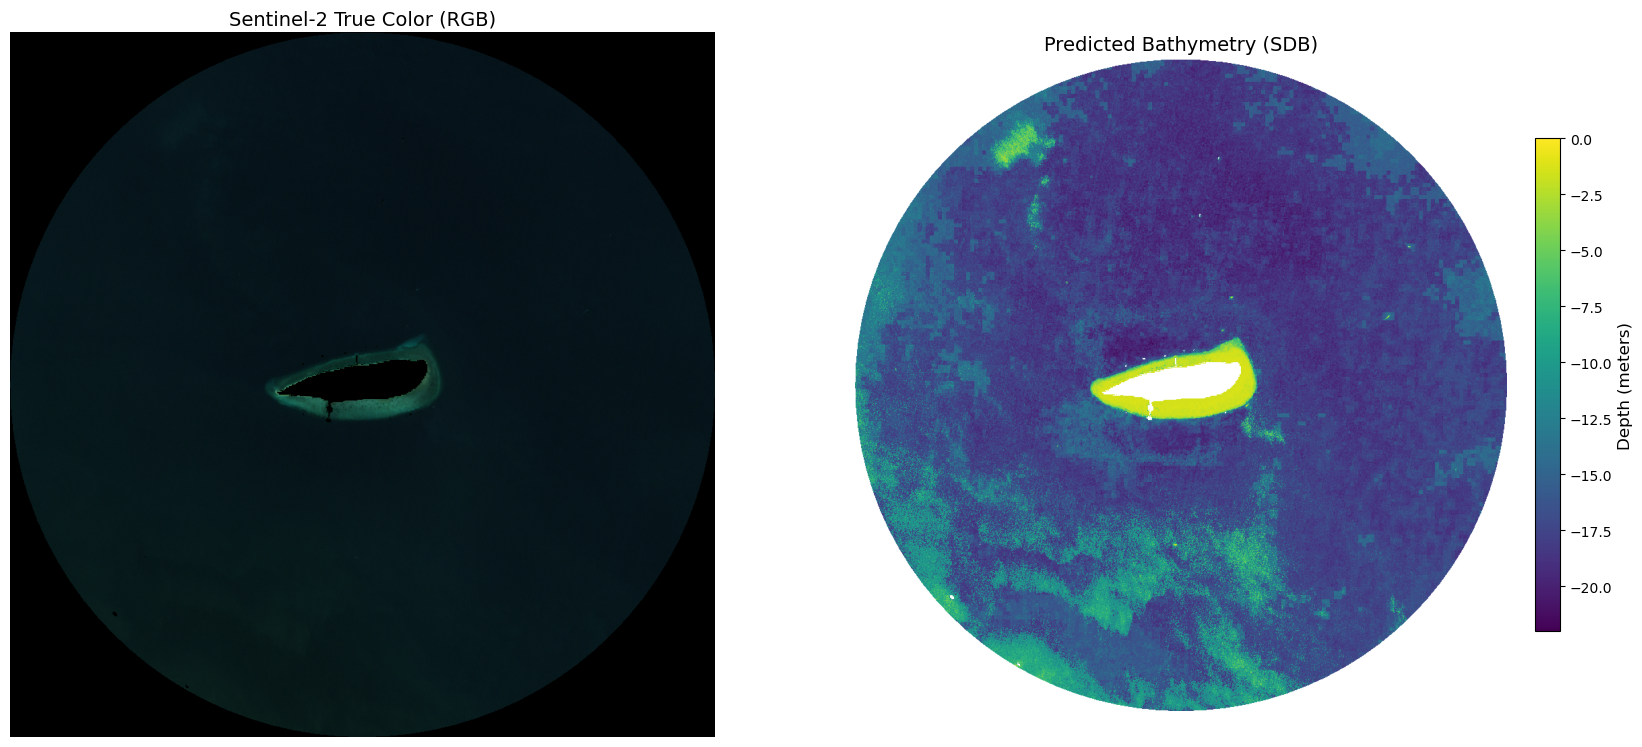

In [8]:
# --- 4. VISUALIZATION ---
print("Generating Map Plots...")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: True Color (RGB)
# Normalize RGB for display (Brightness factor 3.5 for better visibility)
rgb_norm = np.clip(rgb_stack.transpose(1, 2, 0) * 3.5, 0, 1) # Transpose to (H, W, 3)

ax[0].imshow(rgb_norm)
ax[0].set_title('Sentinel-2 True Color (RGB)', fontsize=14)
ax[0].axis('off')

# Plot 2: Predicted Depth Map
# Using 'viridis' colormap (Purple=Deep, Yellow=Shallow)
cmap = plt.get_cmap("viridis")
cmap.set_bad(color='white') # Set NaNs (Land) to white

# vmin and vmax set the depth range for color scaling (e.g., 0 to 30 meters)
im = ax[1].imshow(predicted_depth, cmap=cmap, vmin=0, vmax=-20) 
ax[1].set_title('Predicted Bathymetry (SDB)', fontsize=14)
ax[1].axis('off')

# Add Colorbar
cbar = plt.colorbar(im, ax=ax[1], fraction=0.035, pad=0.04)
cbar.set_label('Depth (meters)', fontsize=12)

# Save Plot
plot_filename = output_filename.replace('.tif', '_plot.png')
plot_path = os.path.join(output_path, plot_filename)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Comparison plot saved: {plot_path}")
plt.show()


In [ ]:
# --- 5. EXPORT GEOTIFF ---
print("Exporting Geotiff...")

# Update metadata for single-band output
raster_meta.update({
    "driver": "GTiff",
    "height": predicted_depth.shape[0],
    "width": predicted_depth.shape[1],
    "count": 1,
    "dtype": 'float32',
    "compress": "lzw",
    "nodata": np.nan
})

# Construct full output path
full_output_path = os.path.join(output_path, output_filename)

with rio.open(full_output_path, 'w', **raster_meta) as dst:
    dst.write(predicted_depth, 1)

print(f"Final Depth Map exported to: {full_output_path}")

Exporting Geotiff...
🎉 Final Depth Map exported to: output_map\SDB_Depth_Map_GiliKetapang.tif
